In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from plotnine import *
from datetime import datetime

In [64]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

# 0. Setup

In [37]:
# save private key to: ../srv/mykey/.quandlapikey
# loading private key
quandl.read_key("../srv/mykey/.quandlapikey")
MonthSymbolList = ["H", "M", "U", "Z"]
start_date = "2020-12-3"
end_date = "2022-08-31"
OptionCodeList = [m+y for y in ("2020", "2021", "2022") for m in MonthSymbolList][4:-2]
plt.style.use('bmh') # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html


In [3]:
try:
    # Do not recreate if it already exists
    fetch_quandl
    print("fetch_quandl already defined")
except NameError:
    @functools.lru_cache(maxsize=16)
    def fetch_quandl(my_sec):
        print("Fetching from Quandl")
        qdata = quandl.get(my_sec)
        return qdata
    print("fetch_quandl has now been newly defined")

fetch_quandl has now been newly defined


In [4]:
def get_futures_data(name, option_code_list, s=start_date, e=end_date):
    Future = pd.DataFrame()
    Dtt = pd.DataFrame()
    f_ls, dtt_ls = [], []
    print(name)
    for code in option_code_list:
        sec_name = "OWF/%s_%s_IVM" % (name, code)
        print("Getting data: " + sec_name)
        data = quandl.get(sec_name, start_date=s, 
                      end_date=e)
        f_ls.append(data.Future)
        dtt_ls.append(data.DtT)
    Future = pd.concat(f_ls, axis=1, join="outer")
    Dtt = pd.concat(dtt_ls, axis=1, join="outer")
    Future.columns = option_code_list
    Dtt.columns = option_code_list
    return Future, Dtt

In [17]:
def cal_sec_mon_future(name, option_code_list, s, e, boundary=30.0):
    future, dtt =  get_futures_data(name, option_code_list, s, e)
    df = dtt[dtt > boundary]
    ls = df.idxmin(axis=1)
    future_price = pd.DataFrame(columns=[name])
    for idx, col in ls.items():
        try:
            future_price.loc[idx, name] = future.loc[idx, col]
        except KeyError:
            continue
    return future_price

# 1. Data

In [18]:
# Student ID: 12375213
# 1. ICE_B_B versus ICE_G_G×0.1147
# 3. CBT_FV_FV versus CBT_TU_TU × 1.1066
# W, X; Y, Z
# X-W; Z-Y
ICE_B_B = cal_sec_mon_future("ICE_B_B", OptionCodeList, s=start_date, e=end_date)
ICE_G_G = cal_sec_mon_future("ICE_G_G", OptionCodeList, s=start_date, e=end_date)
ICE_B_B_ICE_G_G = ICE_B_B.merge(ICE_G_G, left_index=True, right_index=True)

CBT_FV_FV = cal_sec_mon_future("CBT_FV_FV", OptionCodeList, s=start_date, e=end_date)
CBT_TU_TU = cal_sec_mon_future("CBT_TU_TU", OptionCodeList, s=start_date, e=end_date)
CBT_FV_FV_CBT_TU_TU = CBT_FV_FV.merge(CBT_TU_TU, left_index=True, right_index=True)

ICE_B_B
Getting data: OWF/ICE_B_B_H2021_IVM
Getting data: OWF/ICE_B_B_M2021_IVM
Getting data: OWF/ICE_B_B_U2021_IVM
Getting data: OWF/ICE_B_B_Z2021_IVM
Getting data: OWF/ICE_B_B_H2022_IVM
Getting data: OWF/ICE_B_B_M2022_IVM


AttributeError: 'numpy.float64' object has no attribute 'values'

In [ ]:
ICE_B_B_ICE_G_G.tail()

,ICE_B_B,ICE_G_G
2022-03-23,117.75,1054.25
2022-03-24,115.3,1045.25
2022-03-25,117.37,1047.5
2022-03-28,109.49,999.25
2022-03-29,107.71,962.75


In [19]:
CBT_FV_FV_CBT_TU_TU.tail()

,CBT_FV_FV,CBT_TU_TU
2022-05-13,112.960938,105.68125
2022-05-16,113.28125,105.742188
2022-05-17,112.671875,105.51875
2022-05-18,112.914062,105.585938
2022-05-19,113.140625,105.696875


In [34]:
S1 = ICE_B_B_ICE_G_G['ICE_G_G'] * 0.1147 - ICE_B_B_ICE_G_G['ICE_B_B']
S1 = S1.to_frame("spread")

In [21]:
S2 = CBT_FV_FV_CBT_TU_TU["CBT_TU_TU"] * 1.1066 - CBT_FV_FV_CBT_TU_TU["CBT_FV_FV"]
S2 = S2.to_frame("spread")

# 2. Analysis
## 2.1 Check for data matching

In [22]:
print("ICE_B_B - ICE_G_G")
S1.loc[["2021-09-28", "2021-09-29", "2021-11-10"]]

ICE_B_B - ICE_G_G


,spread
2021-09-28,-2.676675
2021-09-29,0.03875
2021-11-10,-0.07795


In [23]:
print("CBT_TU_TU - CBT_FV_FV")
S2.loc[["2021-11-25", "2021-11-26"]]

CBT_TU_TU - CBT_FV_FV


,spread
2021-11-25,0.156306
2021-11-26,-0.181877


## 2.2 Plot

In [56]:
def plot_lines(data, x, y, title):
    fig, ax = plt.subplots()
    ax.plot(data)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.legend(data.columns)
    fig.autofmt_xdate()
    plt.show()

In [58]:
S1_avg = S1.copy()
S1_avg["10D avg"] = S1["spread"].rolling(10).mean()
S1_avg["30D avg"] = S1["spread"].rolling(30).mean()
S1_avg["60D avg"] = S1["spread"].rolling(60).mean()

S2_avg = S2.copy()
S2_avg["10D avg"] = S2["spread"].rolling(10).mean()
S2_avg["30D avg"] = S2["spread"].rolling(30).mean()
S2_avg["60D avg"] = S2["spread"].rolling(60).mean()

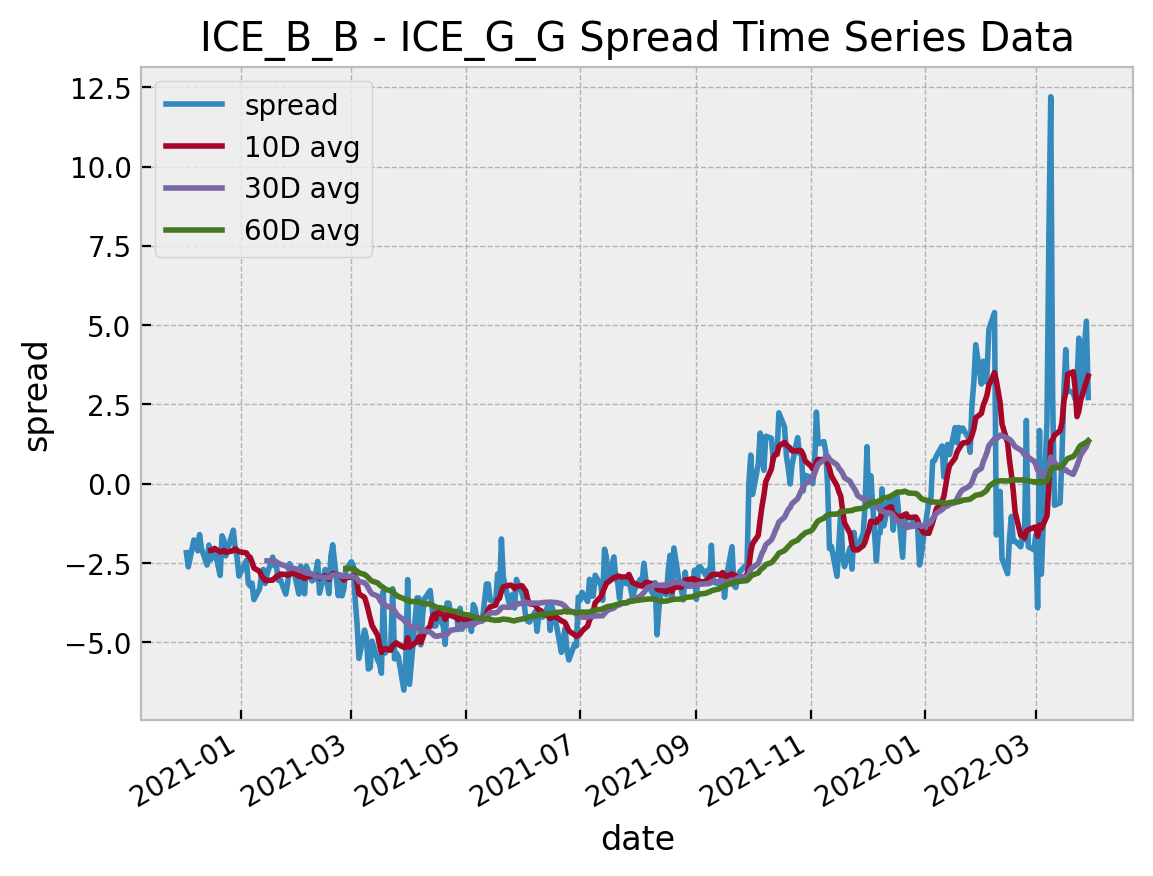

In [66]:
plot_lines(S1_avg, "date", "spread", "ICE_B_B - ICE_G_G Spread Time Series Data")

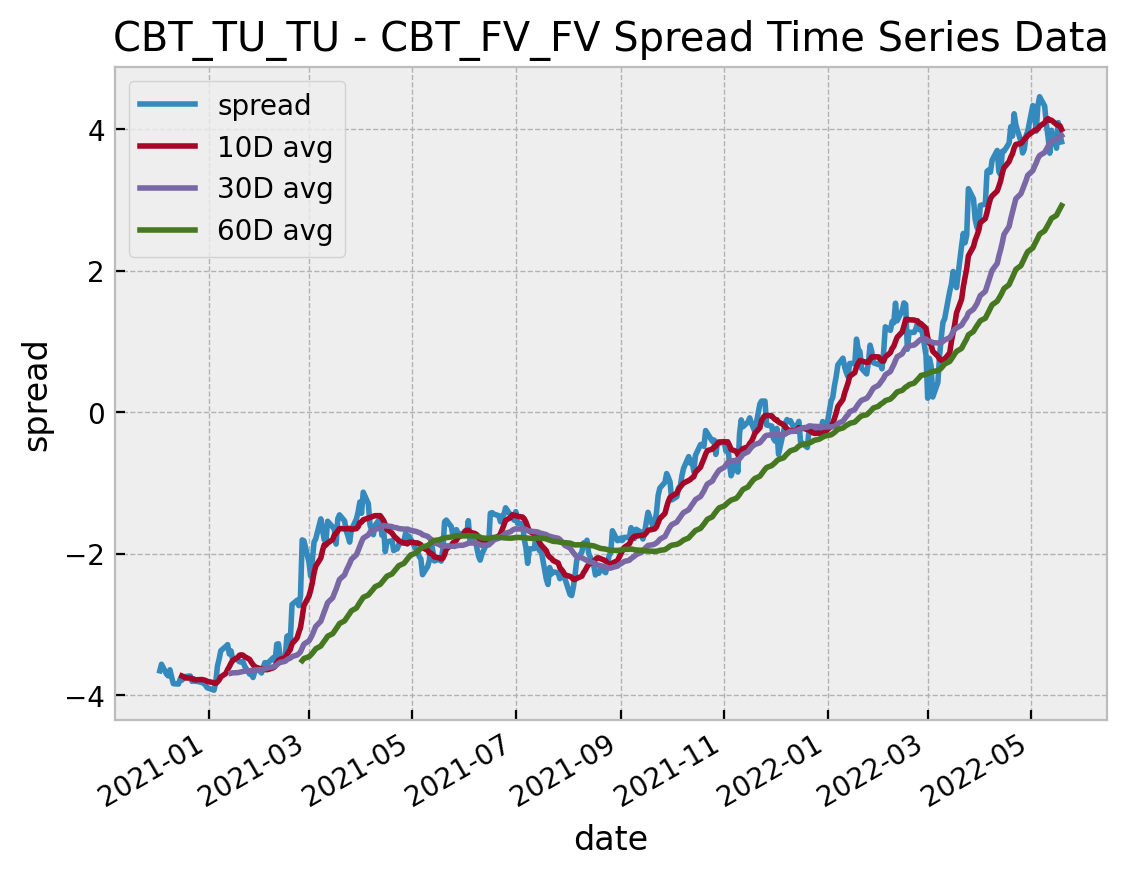

In [67]:
plot_lines(S2_avg, "date", "spread", "CBT_TU_TU - CBT_FV_FV Spread Time Series Data")